# Constructing Dictionary Learning Atlas from MLINDIV rs-fMRI Functional Connectivity

In [22]:
from nilearn import datasets
import glob
import os

subjects = ['014', '019', '020', '021', '024', '025', '027', '033', '043',
            '058', '028', '029', '031', '032', '034', '036', '037', '045', 
            '046', '049', '050', '060', '062', '065', '068', '069', '070', 
            '071', '072', '074', '081', '082', '083', '084', '085', '086', 
            '088', '089', '093', '094', '095', '096', '098', '099', '100',
            '101', '102']


def find_rsfmri_filenames():
    func_filenames = []
    confounds = []
    
    bad_subs = {}
    
    for subject in subjects:
        filename_list = glob.glob('/mnt/chrastil/lab/data/MLINDIV/preprocessed/derivatives/fmriprep/sub-%s/func/sub-%s_task-rest_*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (subject, subject))
        conf_list = glob.glob('/mnt/chrastil/lab/users/rob/projects/MachineLearning/confounds/sub-%s_task-rest_*_conformatted.tsv' % (subject))
        
        if len(filename_list) > 1:

            for file in filename_list:
                size = os.stat(file).st_size
                prev_size = 0
                if size > prev_size:
                    file_to_use = file
                    prev_size = size
            bad_subs[subject] = '%d matching files found, larger file kept (size: %d): %s' % (len(filename_list), size, file_to_use)
            func_filenames.append(file_to_use)
            
            for conf_file in conf_list:
                size = os.stat(conf_file).st_size
                prev_size = 0
                if size > prev_size:
                    conf_file_to_use = file
                    prev_size = size
            confounds.append(conf_file_to_use)

        else:
            func_filenames.append(filename_list[0])
            confounds.append(conf_list[0])

    print(bad_subs)

    return func_filenames, confounds

func_filenames, confounds = find_rsfmri_filenames()




{'095': '2 matching files found, larger file kept (size: 914383985): /mnt/chrastil/lab/data/MLINDIV/preprocessed/derivatives/fmriprep/sub-095/func/sub-095_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'}


47

/opt/jupyterhub/lib/python3.6/site-packages/nilearn/decomposition/base.py:223: UserWarning: Persisting input arguments took 1.19s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  random_state=random_state)
/opt/jupyterhub/lib/python3.6/site-packages/nilearn/decomposition/base.py:223: UserWarning: Persisting input arguments took 1.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  random_state=random

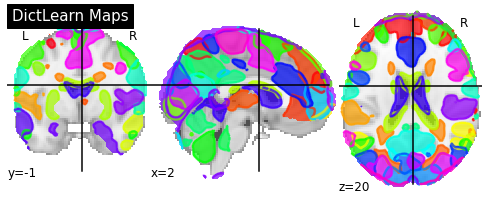

In [23]:
from nilearn.decomposition import DictLearning

dict_learn = DictLearning(n_components=80, smoothing_fwhm=6., 
                          memory = "nilearn_cache", memory_level=2, 
                          random_state = 0)

dict_learn.fit(func_filenames)
components_img = dict_learn.components_img_

from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type = 'filled_contours', title = 'DictLearn Maps')

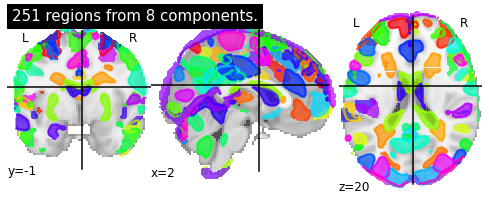

In [24]:
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold = 0.5,
                           thresholding_strategy = 'ratio_n_voxels',
                           extractor = 'local_regions', 
                           standardize = True, min_region_size = 1350)

extractor.fit()

regions_extracted_img = extractor.regions_img_

regions_index = extractor.index_

n_regions_extracted = regions_extracted_img.shape[-1]

title = ('%d regions from %d components.' % (n_regions_extracted, 8))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

In [26]:
components_img.to_filename('/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLINDIV-DL_251_80_rest.nii.gz')
regions_extracted_img.to_filename('/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLINDIV-DL_251_80_rest_EXTRACTED.nii.gz')

Regions extracted file located at: 
	/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLDL_162_thr25_regions.nii.gz


/opt/jupyterhub/lib/python3.6/site-packages/numpy/ma/core.py:2832: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/opt/jupyterhub/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/opt/jupyterhub/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)


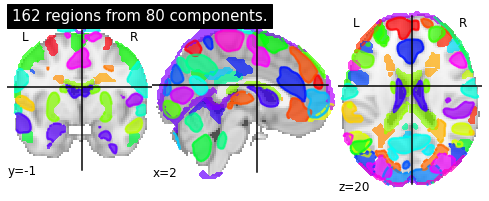

In [2]:
import nilearn
from nilearn.regions import RegionExtractor
from nilearn import plotting

components_img = '/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLINDIV-DL_251_80_rest.nii.gz'
thresh = 0.25

extractor = RegionExtractor(components_img, threshold = thresh,
                           thresholding_strategy = 'ratio_n_voxels',
                           extractor = 'local_regions', 
                           standardize = True, min_region_size = 1500)

extractor.fit()
regions_extracted_img = extractor.regions_img_
regions_index = extractor.index_

n_regions_extracted = regions_extracted_img.shape[-1]

title = ('%d regions from %d components.' % (n_regions_extracted, 80))
extracted_filename = '/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLDL_%s_thr%d_regions.nii.gz' % (n_regions_extracted, thresh*100)
regions_extracted_img.to_filename(extracted_filename)
print("Regions extracted file located at: \n\t%s" % extracted_filename)
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)



In [3]:
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_extracted_img)

In [9]:
import pandas
pandas.set_option('display.float_format', lambda x: '%.3f' % x)

In [10]:
coords_connectome

array([[-4.88679697e+01, -7.65836155e+01,  2.38698319e+00],
       [ 4.77687489e+01, -6.88846919e+01, -2.25005399e+00],
       [-2.63807282e+01,  2.30060479e+00,  6.35604924e+01],
       [-8.34661621e+00, -7.12296614e+01,  5.88549439e+01],
       [ 2.57725532e+01,  5.41016713e+00,  6.31545625e+01],
       [-7.70121090e+00,  5.89030717e+01,  2.27593772e+01],
       [-6.66934596e+01, -3.45825809e+01,  2.81641904e+01],
       [-3.28320144e+01,  1.76143317e+01,  1.03675937e+01],
       [ 3.48650705e+01,  1.69388729e+01,  8.51844208e+00],
       [ 3.54559741e+01,  4.52851613e+01,  2.52401808e+01],
       [ 6.21105496e+01, -3.15642518e+01,  3.52336367e+01],
       [-4.34435473e+01,  4.55501132e+01,  2.80221891e+01],
       [ 3.61102185e+01,  4.72391520e+01,  3.60241964e+01],
       [-6.06182344e-01,  4.24061484e+01, -9.16182418e+00],
       [ 5.99587838e+00,  4.41489937e+01,  4.50740563e+01],
       [ 7.93501282e-01, -1.76889104e+01,  7.61708546e+00],
       [-2.63516693e+01, -7.87470273e+01